# MNIST DATASET


imports

In [1]:
import torch
import torchvision

import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.tensorboard import SummaryWriter

Global tunnings

In [2]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

### Import dataset

Build PyTorch Data loaders

In [3]:
batch_size_train = 64
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './file/',
        train=True,
        download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))  # Normalization: Mean = 0.1307 ; Std deviation = 0.3081;
        ])
    ),
    batch_size=batch_size_train,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        './file/',
        train=False,
        download=True,
        transform=torchvision.transforms.Compose([
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Normalize((0.1307,), (0.3081,))  # Normalization: Mean = 0.1307 ; Std deviation = 0.3081;
        ])
      ),
      batch_size=batch_size_test,
      shuffle=True,
)

#### Visualization

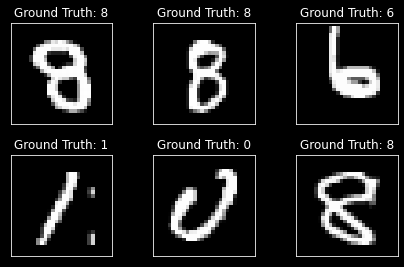

In [14]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])

### Utils

#### Trainer

In [10]:
def train(
    model: nn.Module, optimizer: optim.Optimizer, criterion: nn.CrossEntropyLoss,
    loader: torch.utils.data.DataLoader, n_epochs: int, log_dir: str,
) -> None:

    n_train = len(loader.dataset)
    writer = SummaryWriter(log_dir=log_dir)

    loss_l = []
    for epoch in range(n_epochs):
        average_acc = 0
        average_loss = 0
        
        for batch_idx, (data, target) in enumerate(loader):
            data, target = data.to(DEVICE), target.to(DEVICE)
            optimizer.zero_grad() # Zero the gradient so it doesn't get acumulated
            output = model(data)  # Forward pass

            # Train accuracy
            y_hat = output.data.max(1, keepdim=True)[1]
            train_acc = y_hat.eq(target.data.view_as(y_hat)).sum()
            average_acc += train_acc
            train_acc = train_acc / len(target.data)

            # Update weights
            loss = criterion(output, target) # Calculates loss function
            average_loss += loss.item()
            loss.backward()   # Backpropagation
            optimizer.step()  # Update weights
            
            # Log progress
            if batch_idx % 100 == 0:
                
                n_parsed_items = batch_idx * len(data)
                progress = 100. * batch_idx / len(loader)
                aux = (epoch - 1) * len(loader) + batch_idx # TODO: What does this number mean?
                
                print(f"[epoch %d] [%d/%d (%.2f%%)]\tLoss: %.6f" % (epoch, n_parsed_items, n_train, progress, loss.item()))
                writer.add_scalar('Loss/train', loss.item(), aux)
                writer.add_scalar('Accuracy/train', train_acc, aux)
            
        writer.close()
        loss_l.append(loss.item())

        print("------------------- ---------------------- -----------------")
        print(f"[epoch {epoch}] Average train loss: {average_loss / n_train}")
        print(f"[epoch {epoch}] Average train accuracy: {average_acc / n_train}\n")
            
    plt.plot(loss_l)

#### Tester

In [9]:
def test(model: nn.Module, criterion: nn.CrossEntropyLoss, loader: torch.utils.data.DataLoader) -> None:

    test_loss = 0
    correct = 0
    n_test = len(loader.dataset)

    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(DEVICE), target.to(DEVICE)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= n_test

    accuracy = 100. * correct / n_test
    print(f'\nTest set: Avg. loss: %.4f, Accuracy: %d/%d (%.2f%%)\n' % (test_loss, correct, n_test, accuracy))

## Simple DNN

Parameters & Hyper Parameters

In [14]:
# Dimensions
dim_in = 28 * 28 # Width x Height (pixels)
dim_hidden = 100
dim_out = 10

# Hyper parameters
num_epochs = 10
learning_rate = 0.01
w_decay = 1e-3
momentum = 0.9

### Define network

In [12]:
class Net(nn.Module):

  def __init__(self, dim_in: int, dim_hidden: int, dim_out: int):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(dim_in, dim_hidden)
    self.fc2 = nn.Linear(dim_hidden, dim_out)

  def forward(self, x: torch.Tensor):
    x = x.view(-1, 784) # TODO: What these values?
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

Initialisation


In [15]:
model = Net(dim_in=dim_in, dim_hidden=dim_hidden, dim_out=dim_out).to(DEVICE) # Use GPU (cuda)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=w_decay, momentum=momentum)

### Train $\times$ Test

Train

[epoch 0] [0/60000 (0.00%)]	Loss: 2.276227
[epoch 0] [6400/60000 (10.66%)]	Loss: 0.318867
[epoch 0] [12800/60000 (21.32%)]	Loss: 0.295397
[epoch 0] [19200/60000 (31.98%)]	Loss: 0.167125
[epoch 0] [25600/60000 (42.64%)]	Loss: 0.319535
[epoch 0] [32000/60000 (53.30%)]	Loss: 0.157396
[epoch 0] [38400/60000 (63.97%)]	Loss: 0.151200
[epoch 0] [44800/60000 (74.63%)]	Loss: 0.090059
[epoch 0] [51200/60000 (85.29%)]	Loss: 0.135638
[epoch 0] [57600/60000 (95.95%)]	Loss: 0.127804
------------------- ---------------------- -----------------
[epoch 0] Average train loss: 0.004524655287588636
[epoch 0] Average train accuracy: 0.9149666428565979

[epoch 1] [0/60000 (0.00%)]	Loss: 0.115798
[epoch 1] [6400/60000 (10.66%)]	Loss: 0.119967
[epoch 1] [12800/60000 (21.32%)]	Loss: 0.107541
[epoch 1] [19200/60000 (31.98%)]	Loss: 0.045280
[epoch 1] [25600/60000 (42.64%)]	Loss: 0.234205
[epoch 1] [32000/60000 (53.30%)]	Loss: 0.148154
[epoch 1] [38400/60000 (63.97%)]	Loss: 0.098275
[epoch 1] [44800/60000 (74.63%

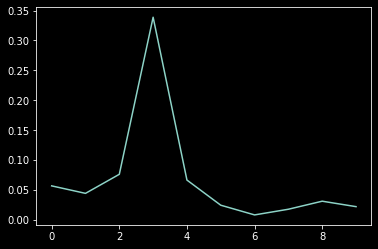

In [16]:
train(
    model=model, optimizer=optimizer, criterion=criterion,
    loader=train_loader, n_epochs=num_epochs, log_dir='file/log/simple_net_train',
)

Test

In [17]:
test(model=model, criterion=criterion, loader=test_loader)


Test set: Avg. loss: 0.0001, Accuracy: 9785/10000 (97.85%)



## Convolutional NN

Parameters & Hyper Parameters

In [4]:
# Dimensions
dim_out = 10

# Hyper parameters
num_epochs = 10
learning_rate = 0.01
w_decay = 1e-3
momentum = 0.9

### Define network

In [5]:
class CNN(nn.Module):
    '''
        01 channel (B&W images)
        10 classes (10 digits in the MNIST set) 
    '''

    def __init__(self, in_channels=1, num_classes=10):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels=10, kernel_size=5) # 2D convolutional layer
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50) # Fully connected
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x): # Step 01
        """
            Input
            > Step 01:  torch.Size([64, 1, 28, 28])

            Convolution 01:
            > Step 02:  torch.Size([64, 10, 24, 24])
            > Step 03:  torch.Size([64, 10, 12, 12])

            Convolution 02:
            > Step 04:  torch.Size([64, 20, 8, 8])
            > Step 05:  torch.Size([64, 20, 8, 8])
            > Step 06:  torch.Size([64, 20, 4, 4])

            Fully connected 01
            > Step 07:  torch.Size([64, 320])
            > Step 08:  torch.Size([64, 50])
            > Step 09:  torch.Size([64, 50])

            Fully connected 02
            > Step 10:  torch.Size([64, 10])

            Output:
            > Step 11:  torch.Size([64, 10])
            >> tensor([-2.6605, -2.4145, -1.9419, -2.5091, -2.3603, -1.7449, -2.4069, -2.3033, -2.4090, -2.7042])
        """

        # Convolution 01
        # x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = self.conv1(x)               # Step 02
        x = F.relu(F.max_pool2d(x, 2))  # Step 03

        # Convolution 02
        # x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = self.conv2(x)               # Step 04
        x = self.conv2_drop(x)          # Step 05
        x = F.relu(F.max_pool2d(x, 2))  # Step 06
        
        # Fully connected 01
        x = x.view(-1, 320) # Step 07
        x = self.fc1(x)     # Step 08
        x = F.dropout(F.relu(x), training=self.training) # Step 09

        # Fully connected 02
        x = self.fc2(x) # Step 10

        # Output
        return F.log_softmax(x, dim=-1) # Step 11

Initialization

In [6]:
model = CNN(in_channels=1, num_classes=dim_out).to(DEVICE) # Use GPU (cuda)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=w_decay, momentum=momentum)

### Train $\times$ Test

Train

In [ ]:
train(
    model=model, optimizer=optimizer, criterion=criterion,
    loader=train_loader, n_epochs=num_epochs, log_dir='file/log/cnn_train',
)

Test

In [11]:
test(model=model, criterion=criterion, loader=test_loader)


Test set: Avg. loss: 0.0001, Accuracy: 9605/10000 (96.05%)

